# BUDT 758J final project
# Group 15
# Team name: Data Ninja

#### Group members:
#### I-Chia Yeh
#### Yi-Ting Lai
#### Cheng-Feng Lin
#### Ching-Yu Ting

# Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import torch
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Load the dataset

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleaning: Train data

In [ ]:
# see the missing values' percentage in each feature
null_df = pd.DataFrame(columns=["Features", "missing values %"])
null_df["Features"] = train.columns
null_df["missing values %"] = np.round(train.isnull().sum().values/train.shape[0], 4).reshape(-1)
null_df.sort_values(by = "missing values %", ascending=False)

,Features,missing values %
72,PoolQC,0.9952
74,MiscFeature,0.9630
6,Alley,0.9377
73,Fence,0.8075
25,MasVnrType,0.5973
...,...,...
27,ExterQual,0.0000
24,Exterior2nd,0.0000
23,Exterior1st,0.0000
22,RoofMatl,0.0000


In [ ]:
# Filter columns in train and test data based on null percentage
# Set the threshold for null percentage
threshold = 0.1

# select columns which null value percentage is lower than the threshold 0.1
select_columns = null_df[null_df['missing values %'] < threshold]["Features"]
y = train["SalePrice"]
data_train = train[select_columns]

# test data should not include the target variable
null_columns_test = select_columns[select_columns != 'SalePrice']
data_test = test[null_columns_test]
data_train.shape, data_test.shape, y.shape
## 7 features were excluded for data_train and data_test

((1460, 74), (1459, 73), (1460,))

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [ ]:
# check for missing values columns in data_train
missing_columns = data_train.columns[data_train.isnull().any()]
print(missing_columns)

Index(['MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')


In [ ]:
# replace categorical and float columns' missing values with 0
for column in missing_columns:
    data_train[column].fillna(0, inplace=True)

# check any remaining NA values in data_train
print(data_train.isnull().any().any())

False


<ipython-input-256-009bb97e94de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[column].fillna(0, inplace=True)


In [ ]:
# check for missing values columns in data_test
missing_columns_test = data_test.columns[data_test.isnull().any()]
print(missing_columns_test)

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrArea',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')


In [ ]:
# replace categorical and float columns' missing values with 0
for column in missing_columns_test:
    data_test[column].fillna(0, inplace=True)

# check any remaining NA values in data_test
print(data_test.isnull().any().any())

False


<ipython-input-258-b3ac90990ef8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test[column].fillna(0, inplace=True)


# Exploratory Data Analysis

In [ ]:
# Heatmap for numerical features
# Select only the numeric columns
select_data=data_train[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'GrLivArea','SalePrice', 'FullBath', 'GarageArea', 'ScreenPorch', 'PoolArea']]

# Compute correlation matrix
correlation_matrix = select_data.corr()
print(correlation_matrix)

              LotArea  OverallQual  OverallCond  MasVnrArea  GrLivArea  \
LotArea      1.000000     0.105806    -0.005636    0.103321   0.263116   
OverallQual  0.105806     1.000000    -0.091932    0.407252   0.593007   
OverallCond -0.005636    -0.091932     1.000000   -0.125694  -0.079686   
MasVnrArea   0.103321     0.407252    -0.125694    1.000000   0.388052   
GrLivArea    0.263116     0.593007    -0.079686    0.388052   1.000000   
SalePrice    0.263843     0.790982    -0.077856    0.472614   0.708624   
FullBath     0.126031     0.550600    -0.194149    0.272999   0.630012   
GarageArea   0.180403     0.562022    -0.151521    0.370884   0.468997   
ScreenPorch  0.043160     0.064886     0.054811    0.062248   0.101510   
PoolArea     0.077672     0.065166    -0.001985    0.011928   0.170205   

             SalePrice  FullBath  GarageArea  ScreenPorch  PoolArea  
LotArea       0.263843  0.126031    0.180403     0.043160  0.077672  
OverallQual   0.790982  0.550600    0.562022 

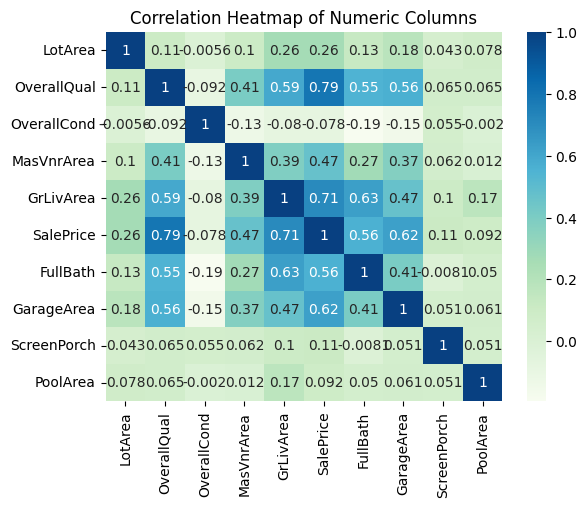

In [ ]:
# Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='GnBu')
plt.xticks(rotation=90)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

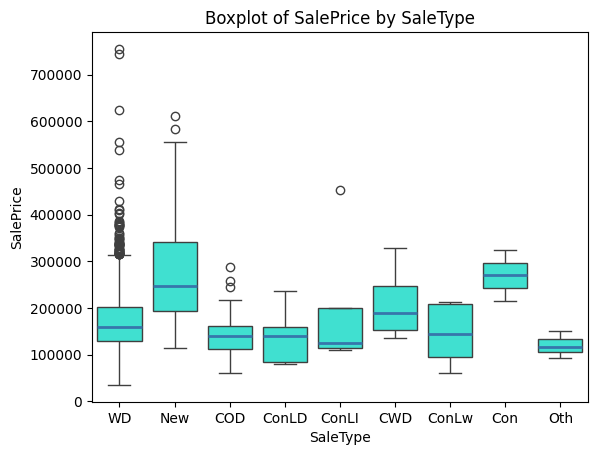

In [ ]:
# Boxplot for discovering the distribution of SaleType vs SalePrice
sns.boxplot(
    data= data_train, x="SaleType", y="SalePrice", notch= False, showcaps=True,
    flierprops={"marker": "o"},
    boxprops={"facecolor": 'turquoise'},
    medianprops={"color": "#3776ab", "linewidth": 2})
plt.title('Boxplot of SalePrice by SaleType')
plt.show()

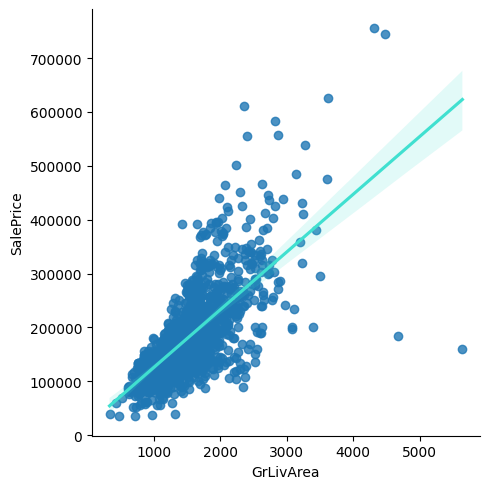

In [ ]:
sns.lmplot(data=data_train, x='GrLivArea', y='SalePrice', line_kws={'color': 'turquoise'})
plt.show()

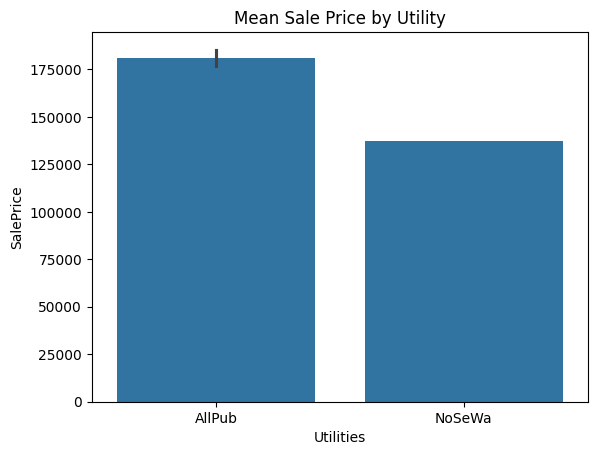

In [ ]:
# Create a bar chart
sns.barplot(x='Utilities', y='SalePrice', data=data_train)
plt.title('Mean Sale Price by Utility')
plt.show()

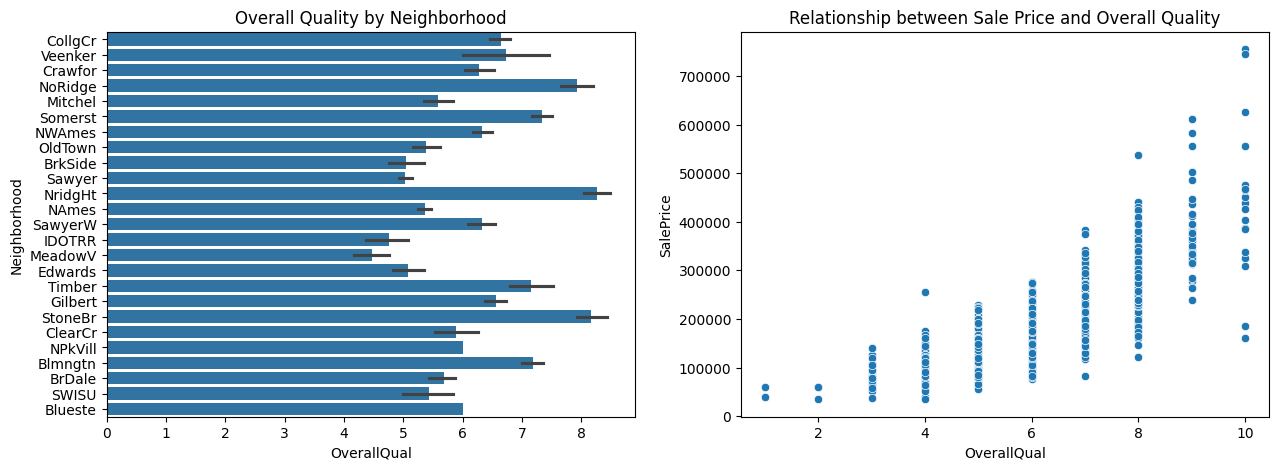

In [ ]:
#Relationship among overall Quality, neighborhood and sale price

#Quality vs Neighborhood
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.barplot(x='OverallQual', y='Neighborhood', data=data_train, ax=axs[0])
axs[0].set_title('Overall Quality by Neighborhood')

#Quality vs Sale Price
sns.scatterplot(x='OverallQual', y='SalePrice', data=data_train, ax=axs[1])
axs[1].set_title('Relationship between Sale Price and Overall Quality')

plt.show()

<ipython-input-265-986f87bac5d0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='HeatingQC', y='SalePrice', data=data_train, ax=axs[1], palette='Set3')


Text(0.5, 1.0, 'Sale Price by Heating Quality')

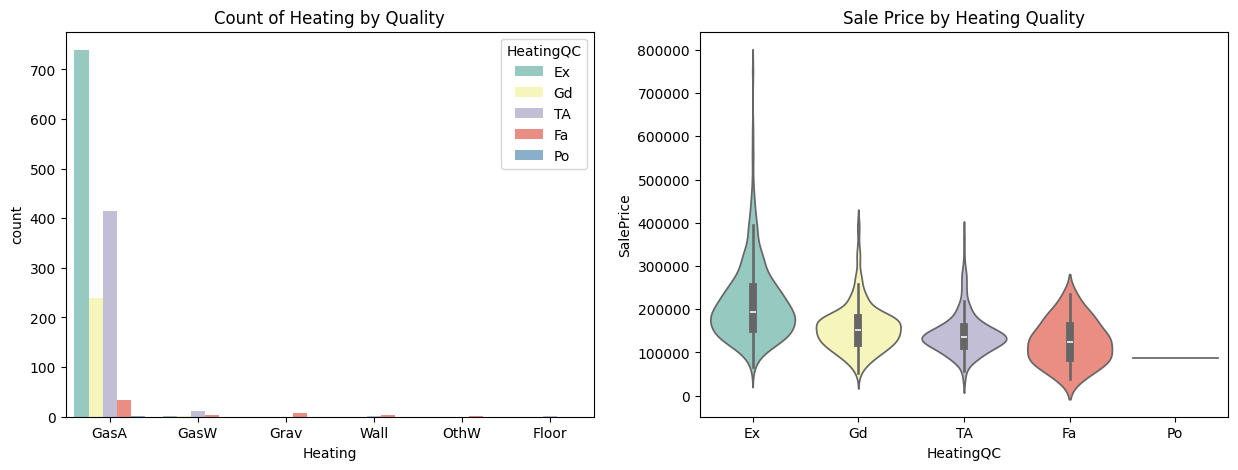

In [ ]:
#Heating Tyep and Quality

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# Number of each Heating Quality by Heating Type
sns.countplot(x='Heating', hue='HeatingQC', data=data_train, ax=axs[0], palette='Set3')
axs[0].set_title('Count of Heating by Quality')
# Sale price vs Heating Quality
sns.violinplot(x='HeatingQC', y='SalePrice', data=data_train, ax=axs[1], palette='Set3')
axs[1].set_title('Sale Price by Heating Quality')

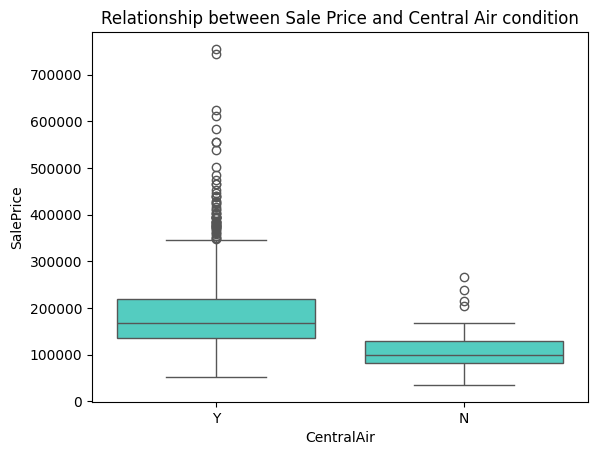

In [ ]:
#central air
sns.boxplot(x='CentralAir', y='SalePrice', data=data_train, color='turquoise')
plt.title('Relationship between Sale Price and Central Air condition')
plt.show()

# Feature Engineering

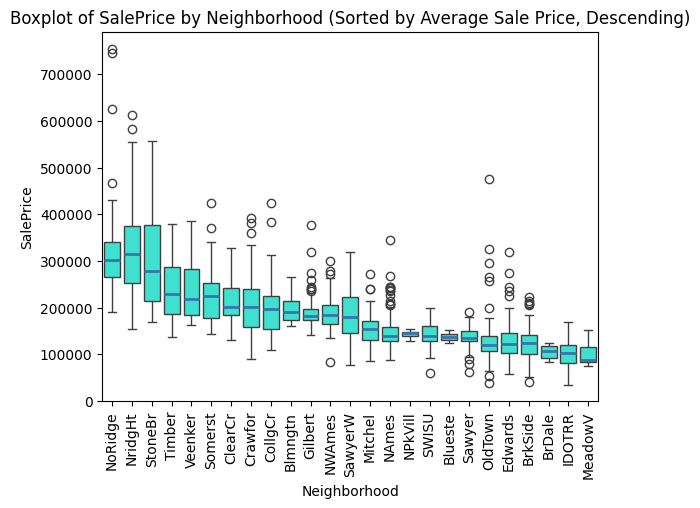

In [ ]:
# New features: 'expensive_neighbor'
# represent the neighborhood having the average price is in top 13 neighboors
# calculate average sale price for each neighborhood
average_sale_price_by_neighborhood = data_train.groupby('Neighborhood')['SalePrice'].mean()

# sort neighborhoods based on average sale price in descending order
sorted_neighborhoods = average_sale_price_by_neighborhood.sort_values(ascending=False).index

# plotting
sns.boxplot(
    data=data_train, x="Neighborhood", y="SalePrice", order=sorted_neighborhoods,
    notch=False, showcaps=True,
    flierprops={"marker": "o"},
    boxprops={"facecolor": 'turquoise'},
    medianprops={"color": "#3776ab", "linewidth": 2})

plt.title('Boxplot of SalePrice by Neighborhood (Sorted by Average Sale Price, Descending)')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# define the high_price_neighborhoods
high_price_neighborhoods = sorted_neighborhoods[:13]

# Create a new column 'expensive_neighbor'
data_train['expensive_neighbor'] = data_train['Neighborhood'].isin(high_price_neighborhoods).astype(bool)

data_train['expensive_neighbor'].describe()

<ipython-input-268-b30962f0ae75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['expensive_neighbor'] = data_train['Neighborhood'].isin(high_price_neighborhoods).astype(bool)


count     1460
unique       2
top       True
freq       735
Name: expensive_neighbor, dtype: object

In [ ]:
# New features: 'YearGroup'
# check the SalePrice distribution
data_train.SalePrice.describe()

# group the housed depends on their salePrice
salePrice_1q = 129975
salePrice_2q = 163000
salePrice_3q = 214000
low_price_house = data_train[data_train.SalePrice <= salePrice_1q]
mdlow_price_house = data_train[(data_train.SalePrice > salePrice_1q) & (data_train.SalePrice <= salePrice_2q)]
mdhigh_price_house = data_train[(data_train.SalePrice > salePrice_2q) & (data_train.SalePrice <= salePrice_3q)]
high_price_house = data_train[data_train.SalePrice > salePrice_3q]

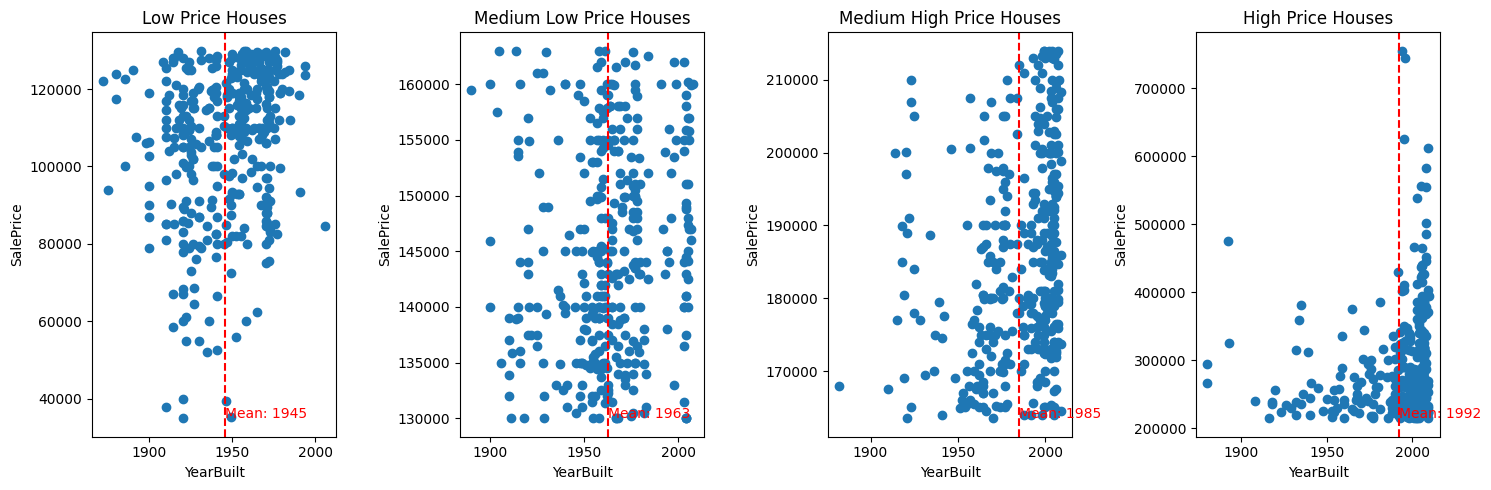

In [ ]:
# plotting
plt.figure(figsize=(15, 5))

# low_price_house
plt.subplot(1, 4, 1)
plt.scatter(low_price_house.YearBuilt, low_price_house.SalePrice)
plt.axvline(x=low_price_house['YearBuilt'].mean(), color='r', linestyle='--')
plt.text(low_price_house['YearBuilt'].mean(), min(low_price_house['SalePrice']), f'Mean: {low_price_house["YearBuilt"].mean():.0f}', color='r')
plt.xlabel('YearBuilt')
plt.ylabel('SalePrice')
plt.title('Low Price Houses')

# mdlow_price_house
plt.subplot(1, 4, 2)
plt.scatter(mdlow_price_house.YearBuilt, mdlow_price_house.SalePrice)
plt.axvline(x=mdlow_price_house['YearBuilt'].mean(), color='r', linestyle='--')
plt.text(mdlow_price_house['YearBuilt'].mean(), min(mdlow_price_house['SalePrice']), f'Mean: {mdlow_price_house["YearBuilt"].mean():.0f}', color='r')
plt.xlabel('YearBuilt')
plt.ylabel('SalePrice')
plt.title('Medium Low Price Houses')

# mdhigh_price_house
plt.subplot(1, 4, 3)
plt.scatter(mdhigh_price_house.YearBuilt, mdhigh_price_house.SalePrice)
plt.axvline(x=mdhigh_price_house['YearBuilt'].mean(), color='r', linestyle='--')
plt.text(mdhigh_price_house['YearBuilt'].mean(), min(mdhigh_price_house['SalePrice']), f'Mean: {mdhigh_price_house["YearBuilt"].mean():.0f}', color='r')
plt.xlabel('YearBuilt')
plt.ylabel('SalePrice')
plt.title('Medium High Price Houses')

# high_price_house
plt.subplot(1, 4, 4)
plt.scatter(high_price_house.YearBuilt, high_price_house.SalePrice)
plt.axvline(x=high_price_house['YearBuilt'].mean(), color='r', linestyle='--')
plt.text(high_price_house['YearBuilt'].mean(), min(high_price_house['SalePrice']), f'Mean: {high_price_house["YearBuilt"].mean():.0f}', color='r')
plt.xlabel('YearBuilt')
plt.ylabel('SalePrice')
plt.title('High Price Houses')

plt.tight_layout()
plt.show()

In [ ]:
# define the conditions and corresponding values
conditions = [
    data_train['YearBuilt'] <= low_price_house['YearBuilt'].mean(),
    (data_train['YearBuilt'] > low_price_house['YearBuilt'].mean()) & (data_train['YearBuilt'] <= mdlow_price_house['YearBuilt'].mean()),
    (data_train['YearBuilt'] > mdlow_price_house['YearBuilt'].mean()) & (data_train['YearBuilt'] <= mdhigh_price_house['YearBuilt'].mean()),
    (data_train['YearBuilt'] > mdhigh_price_house['YearBuilt'].mean()) & (data_train['YearBuilt'] <= high_price_house['YearBuilt'].mean())]

values = [1, 2, 3, 4]

# create "YearGroup" indicating the year group based on the conditions
data_train['YearGroup'] = np.select(conditions, values, default=5) # default for the houses whose 'YearBuilt' is newer than the mean of high_price_house

print(data_train[['YearBuilt', 'YearGroup']])

      YearBuilt  YearGroup
0          2003          5
1          1976          3
2          2001          5
3          1915          1
4          2000          5
...         ...        ...
1455       1999          5
1456       1978          3
1457       1941          1
1458       1950          2
1459       1965          3

[1460 rows x 2 columns]


<ipython-input-271-d86e303c27dc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['YearGroup'] = np.select(conditions, values, default=5) # default for the houses whose 'YearBuilt' is newer than the mean of high_price_house


In [ ]:
#count total liveing area
data_train['Total_Living_Area'] = data_train['1stFlrSF'] + data_train['2ndFlrSF'] + data_train['GrLivArea']

# count outdoor area
data_train['Total_Outdoor_Area'] = data_train['WoodDeckSF'] + data_train['OpenPorchSF'] +\
 data_train['EnclosedPorch'] + data_train['3SsnPorch'] + data_train['ScreenPorch'] + data_train['PoolArea']
data_train.loc[data_train['Total_Outdoor_Area'] == 0, 'Total_Outdoor_Area'] = 1
#Indoor to Outdoor Living Space Ratio
data_train['Indoor_Outdoor_Ratio'] = data_train['Total_Living_Area'] / data_train['Total_Outdoor_Area']
data_train.drop(['Total_Living_Area','Total_Outdoor_Area'],axis=1)
#do a energy efficiency index by heatingQC socre and centralair score
heating_quality_scores = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
data_train['HeatingQC_Score'] = data_train['HeatingQC'].map(heating_quality_scores)
data_train['CentralAir_Score'] = data_train['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)
data_train['Energy_Efficiency_Index'] = data_train['HeatingQC_Score'] + data_train['CentralAir_Score']

# count luxury amenity by amenity quality
data_train['Luxury_Amenity_Count'] =  (data_train['GarageQual'].isin(['Ex', 'Gd']).astype(int))+\
  (data_train['KitchenQual'].isin(['Ex', 'Gd']).astype(int))+(data_train['BsmtQual'].isin(['Ex', 'Gd']).astype(int))

# code reference:
# .map() https://www.geeksforgeeks.org/python-map-function/

<ipython-input-272-2cf82e0faf68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Total_Living_Area'] = data_train['1stFlrSF'] + data_train['2ndFlrSF'] + data_train['GrLivArea']
<ipython-input-272-2cf82e0faf68>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Total_Outdoor_Area'] = data_train['WoodDeckSF'] + data_train['OpenPorchSF'] +\
<ipython-input-272-2cf82e0faf68>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

# Feature selection

In [ ]:
data_dummy = pd.get_dummies(data_train,drop_first = True).astype(int)
data_dummy.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,196,706,0,...,0,0,0,0,1,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162,486,0,...,0,0,0,0,1,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,350,655,0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
X = data_dummy.drop('SalePrice', axis=1)
y = data_dummy['SalePrice']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

lasso_cv = LassoCV(cv=100, random_state=42, max_iter=10000)
lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_
print("Best alpha:", best_alpha)

y_pred = lasso_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# code reference:
# LassoCV(cv=_, random_state=_, max_iter=_) https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.LassoCV.html
# mean_squared_error(y_test, y_pred) https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

Best alpha: 1843.2594431078876
Test MSE: 937579406.4776461


In [ ]:
model = Lasso(alpha=best_alpha)
model.fit(data_dummy.drop('SalePrice', axis=1), data_dummy['SalePrice'])

importance = np.abs(model.coef_)
importance_df = pd.DataFrame(importance, index=data_dummy.drop('SalePrice', axis=1).columns, columns=['Importance'])

zero_importance_cols = importance_df[importance_df['Importance'] == 0].index
data_dummy = data_dummy.drop(columns=zero_importance_cols)

In [ ]:
data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Id                    1460 non-null   int64
 1   MSSubClass            1460 non-null   int64
 2   LotArea               1460 non-null   int64
 3   OverallQual           1460 non-null   int64
 4   OverallCond           1460 non-null   int64
 5   YearBuilt             1460 non-null   int64
 6   YearRemodAdd          1460 non-null   int64
 7   MasVnrArea            1460 non-null   int64
 8   BsmtFinSF1            1460 non-null   int64
 9   BsmtFinSF2            1460 non-null   int64
 10  TotalBsmtSF           1460 non-null   int64
 11  1stFlrSF              1460 non-null   int64
 12  2ndFlrSF              1460 non-null   int64
 13  LowQualFinSF          1460 non-null   int64
 14  GrLivArea             1460 non-null   int64
 15  BedroomAbvGr          1460 non-null   int64
 16  Firepl

# Data Cleaning: Test data

In [ ]:
test_id = data_test['Id'].copy()
test_id

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [ ]:
# New features: 'expensive_neighbor'
# represent the neighborhood having the average price is in top 13 neighboors
# calculate average sale price for each neighborhood
average_sale_price_by_neighborhood = data_train.groupby('Neighborhood')['SalePrice'].mean()

# sort neighborhoods based on average sale price in descending order
sorted_neighborhoods = average_sale_price_by_neighborhood.sort_values(ascending=False).index

high_price_neighborhoods = sorted_neighborhoods[:13]

# Create a new column 'expensive_neighbor'
data_test['expensive_neighbor'] = data_train['Neighborhood'].isin(high_price_neighborhoods).astype(bool)

data_test['expensive_neighbor'].describe()

# code reference:
# .astype(bool) https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html

<ipython-input-279-67448fcf4943>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['expensive_neighbor'] = data_train['Neighborhood'].isin(high_price_neighborhoods).astype(bool)


count     1459
unique       2
top       True
freq       735
Name: expensive_neighbor, dtype: object

In [ ]:
conditions_test= [
    data_test['YearBuilt'] <= 1945,
    (data_test['YearBuilt'] > 1945 )& (data_test['YearBuilt'] <= 1963),
    (data_test['YearBuilt'] > 1963 ) & (data_test['YearBuilt'] <= 1985),
    (data_test['YearBuilt'] > 1985) & (data_test['YearBuilt'] <= 1992)]

values = [1, 2, 3, 4]

# create "YearGroup" indicating the year group based on the conditions
data_test['YearGroup'] = np.select(conditions_test, values, default=5) # default for the houses whose 'YearBuilt' is newer than the mean of high_price_house

print(data_test[['YearBuilt', 'YearGroup']])

      YearBuilt  YearGroup
0          1961          2
1          1958          2
2          1997          5
3          1998          5
4          1992          4
...         ...        ...
1454       1970          3
1455       1970          3
1456       1960          2
1457       1992          4
1458       1993          5

[1459 rows x 2 columns]


<ipython-input-280-111aaa23e562>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['YearGroup'] = np.select(conditions_test, values, default=5) # default for the houses whose 'YearBuilt' is newer than the mean of high_price_house


In [ ]:
#count total liveing area
data_test['Total_Living_Area'] = data_test['1stFlrSF'] + data_test['2ndFlrSF'] + data_test['GrLivArea']

# count outdoor area
data_test['Total_Outdoor_Area'] = data_test['WoodDeckSF'] + data_test['OpenPorchSF'] +\
 data_test['EnclosedPorch'] + data_test['3SsnPorch'] + data_test['ScreenPorch'] + data_test['PoolArea']
data_test.loc[data_test['Total_Outdoor_Area'] == 0, 'Total_Outdoor_Area'] = 1
#Indoor to Outdoor Living Space Ratio
data_test['Indoor_Outdoor_Ratio'] = data_test['Total_Living_Area'] / data_test['Total_Outdoor_Area']
data_test.drop(['Total_Living_Area','Total_Outdoor_Area'],axis=1)
#do a energy efficiency index by heatingQC socre and centralair score
heating_quality_scores = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
data_test['HeatingQC_Score'] = data_test['HeatingQC'].map(heating_quality_scores)
data_test['CentralAir_Score'] = data_test['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)
data_test['Energy_Efficiency_Index'] = data_test['HeatingQC_Score'] + data_test['CentralAir_Score']

# count luxury amenity by amenity quality
data_test['Luxury_Amenity_Count'] =  (data_test['GarageQual'].isin(['Ex', 'Gd']).astype(int))+\
  (data_test['KitchenQual'].isin(['Ex', 'Gd']).astype(int))+(data_test['BsmtQual'].isin(['Ex', 'Gd']).astype(int))

<ipython-input-281-d082cf523eba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Total_Living_Area'] = data_test['1stFlrSF'] + data_test['2ndFlrSF'] + data_test['GrLivArea']
<ipython-input-281-d082cf523eba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Total_Outdoor_Area'] = data_test['WoodDeckSF'] + data_test['OpenPorchSF'] +\
<ipython-input-281-d082cf523eba>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [ ]:
data_dummy_test = pd.get_dummies(data_test,drop_first = True).astype(int)
data_dummy_test.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,11622,5,6,1961,1961,0,468,144,...,0,0,0,0,1,0,0,0,1,0
1,1462,20,14267,6,6,1958,1958,108,923,0,...,0,0,0,0,1,0,0,0,1,0
2,1463,60,13830,5,5,1997,1998,0,791,0,...,0,0,0,0,1,0,0,0,1,0
3,1464,60,9978,6,6,1998,1998,20,602,0,...,0,0,0,0,1,0,0,0,1,0
4,1465,120,5005,8,5,1992,1992,0,263,0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
missing_in_test = set(data_dummy.columns) - set(data_dummy_test.columns)

# Add these columns to data_dummy_test, filled with zeros
for column in missing_in_test:
    data_dummy_test[column] = 0

extra_in_test = set(data_dummy_test.columns) - set(data_dummy.columns)

# Drop these columns from data_dummy_test
data_dummy_test = data_dummy_test.drop(columns=extra_in_test)
data_dummy_test = data_dummy_test[data_dummy.columns]

In [ ]:
print(data_dummy.shape)
print(data_dummy_test.shape)

(1460, 33)
(1459, 33)


In [ ]:
data_dummy_test = data_dummy_test.drop('SalePrice',axis=1)

In [ ]:
data_dummy_test.shape

(1459, 32)

# Modeling

In [ ]:
X = data_dummy.drop('SalePrice', axis=1)
y = data_dummy['SalePrice']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# scaler.fit_transform() https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

##1. Linear regression

In [ ]:
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate and print performance metrics
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred, squared=False))
print("R-squared ):", r2_score(y_test, y_pred))

# MAE, MSE, R^2 https://www.studytonight.com/post/what-is-mean-squared-error-mean-absolute-error-root-mean-squared-error-and-r-squared

Mean Absolute Error (MAE): 20927.020207671685
Mean Squared Error (MSE): 1086986579.2912009
Root Mean Squared Error (RMSE): 32969.47951198503
R-squared ): 0.8442287225523201


In [ ]:
# Predict test data in linear regression model
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(data_dummy_test)


predicted = model.predict(X_test_scaled)

# write the output data
results_df = pd.DataFrame(predicted, columns=['SalePrice'])
results_df['Id'] = test_id
results_df = results_df[['Id', 'SalePrice']]

results_df.to_csv('prediction_results.csv', index=False)

## 2. Random Forest

In [ ]:
# Define the RandomForest model
model = RandomForestRegressor(n_estimators=80, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error of Random Forest model: {mae}")
print(f"Mean Squared Error of Random Forest model: {mse}")
print(f"R-squared score of Random Forest model: {r2}")

# RandomForestRegressor https://www.geeksforgeeks.org/random-forest-regression-in-python/

Mean Absolute Error of Random Forest model: 17088.957848173515
Mean Squared Error of Random Forest model: 750548218.320761
R-squared score of Random Forest model: 0.8924422279158755


In [ ]:
rf_predict = model.predict(data_dummy_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
# Create a DataFrame for the predictions
rf_predict_df = pd.DataFrame(rf_predict, columns=['SalePrice'])
rf_predict_df['Id'] = test_id
rf_predict_df = rf_predict_df[['Id', 'SalePrice']]

# Save the predictions to a CSV file
rf_predict_df.to_csv('rf_prediction_results.csv', index=False)

## 3. XGBoost

In [ ]:
#https://www.kaggle.com/code/xiefei/02-house/notebook
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.05,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.8, n_estimators=2200,
                             reg_alpha=0.5, reg_lambda=0.8,
                             subsample=0.5, random_state=7, nthread=-1)

# xgb reference
# https://xgboost.readthedocs.io/en/stable/python/python_intro.html

In [ ]:
from sklearn.metrics import mean_absolute_error

model_xgb.fit(X_train, y_train)

# Predictions on training set
xgb_train_pred = model_xgb.predict(X_test)

# Calculate MAE
mae_train = mean_absolute_error(y_test, xgb_train_pred)
print("Training MAE:", mae_train)

Training MAE: 16624.351517908104


In [ ]:
# tuning the learning_rate
mae_xgb = []

for learning_rate in np.arange(0.0001, 0.0500, 0.0009):
    model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.05,
                             learning_rate=learning_rate, max_depth=3,
                             min_child_weight=1.8, n_estimators=2200,
                             reg_alpha=0.5, reg_lambda=0.8,
                             subsample=0.5, random_state=7, nthread=-1)
    model_xgb.fit(X_train, y_train)
    xgb_test_pred = model_xgb.predict(X_test)
    mae = mean_absolute_error(y_test, xgb_test_pred)
    mae_xgb.append(mae)

# XGBRegressor
# https://xgboost.readthedocs.io/en/stable/python/python_api.html

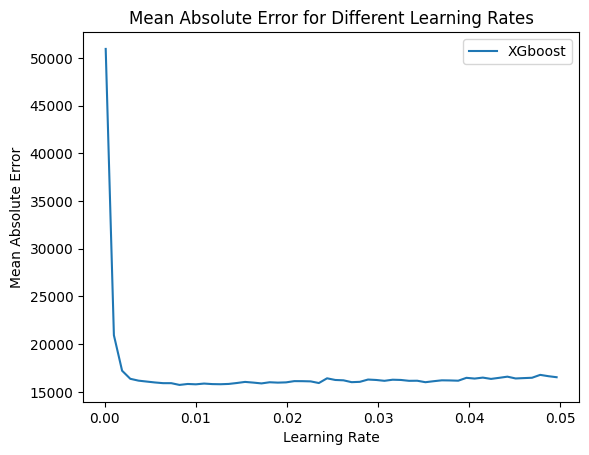

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame with MAE values and learning rates as index
df_acc = pd.DataFrame({'XGboost': mae_xgb},
                      index=np.arange(0.0001, 0.0500, 0.0009))

# Plot the lineplot
acc_line = sns.lineplot(data=df_acc, dashes=False)
acc_line.set_xlabel('Learning Rate')
acc_line.set_ylabel('Mean Absolute Error')
acc_line.set_title('Mean Absolute Error for Different Learning Rates')

# Show the plot
plt.show()

In [ ]:
# find the optimal learning rate
best_learning_rate = df_acc['XGboost'].idxmin()
print("Best Learning Rate:", best_learning_rate)


model_xgb_optimal = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.05,
                             learning_rate=best_learning_rate, max_depth=3,
                             min_child_weight=1.8, n_estimators=2200,
                             reg_alpha=0.5, reg_lambda=0.8,
                             subsample=0.5, random_state=7, nthread=-1)

Best Learning Rate: 0.008199999999999999


In [ ]:
# retrain the model with the optimal learning rate using the training data
model_xgb_optimal.fit(X_train, y_train)

# Make predictions on the test data
xgb_test_pred = model_xgb_optimal.predict(data_dummy_test)

In [ ]:
xgb_predict_df = pd.DataFrame(xgb_test_pred, columns=['SalePrice'])
xgb_predict_df['Id'] = test_id
xgb_predict_df = xgb_predict_df[['Id', 'SalePrice']]

xgb_predict_df.to_csv('xgb_prediction_results.csv', index=False)

## 4. Keras

In [ ]:
X = data_dummy.drop('SalePrice', axis=1)
y = data_dummy['SalePrice']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape

((1022, 32), (1022,))

In [ ]:
# Set global variables for both Keras and Torch:
seed = 42
batch_size = 60
epochs = 8

In [ ]:
# Keras Model: scale both X(features) and y(target variables)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define model architecture
model = keras.Sequential(layers = [
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(1),
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_scaled))

Epoch 1/8
18/18 [==============================] - 1s 14ms/step - loss: 0.3881 - mae: 0.4086 - val_loss: 0.1880 - val_mae: 0.2752
Epoch 2/8
18/18 [==============================] - 0s 5ms/step - loss: 0.1871 - mae: 0.2582 - val_loss: 0.1618 - val_mae: 0.2611
Epoch 3/8
18/18 [==============================] - 0s 5ms/step - loss: 0.1566 - mae: 0.2385 - val_loss: 0.1609 - val_mae: 0.2481
Epoch 4/8
18/18 [==============================] - 0s 5ms/step - loss: 0.1321 - mae: 0.2200 - val_loss: 0.1593 - val_mae: 0.2461
Epoch 5/8
18/18 [==============================] - 0s 6ms/step - loss: 0.1176 - mae: 0.2079 - val_loss: 0.1633 - val_mae: 0.2427
Epoch 6/8
18/18 [==============================] - 0s 6ms/step - loss: 0.1091 - mae: 0.2017 - val_loss: 0.1433 - val_mae: 0.2403
Epoch 7/8
18/18 [==============================] - 0s 11ms/step - loss: 0.1066 - mae: 0.1967 - val_loss: 0.1505 - val_mae: 0.2437
Epoch 8/8
18/18 [==============================] - 0s 8ms/step - loss: 0.1001 - mae: 0.1998 - v

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 0s 3ms/step - loss: 39380713472.0000 - mae: 180007.7031
Test Loss: 39380713472.0
Test Accuracy: 180007.703125


In [ ]:
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras

seed = 20742
epochs = 2

# Assuming X_train and y_train are defined

df_models = pd.DataFrame(columns=['optimizer',
                                   'loss',
                                   'units_layer',
                                   'activation',
                                   'batch_size',
                                   'validation_split',
                                   'mae'])
# using different paremeters to find optimal result
for optimizer in ['adam', 'sgd']:
    for loss in ['mae', 'mean_squared_error']:
        for units_layer in [500, 300, 100]:
            for activation in ['sigmoid', 'relu', 'tanh']:
                for batch_size in [30, 60, 100]:
                    for validation_split in [0.2, 0.3]:
                        keras.backend.clear_session()
                        random.seed(seed)
                        np.random.seed(seed)
                        tf.random.set_seed(seed)

                        model = keras.Sequential([
                            keras.layers.Flatten(input_shape=(X_train.shape[1],)),
                            keras.layers.Dense(units_layer, activation=activation),
                            keras.layers.Dense(1)
                        ])

                        model.compile(optimizer=optimizer,
                                      loss=loss,
                                      metrics=['mae'])

                        history = model.fit(X_train, y_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_split=validation_split)

                        # Calculate mean MAE over epochs
                        mean_mae = np.mean(history.history['mae'])

                        df_models.loc[len(df_models)] = [optimizer,
                                                         loss,
                                                         units_layer,
                                                         activation,
                                                         batch_size,
                                                         validation_split,
                                                         mean_mae]


# Different parameters for Keras model: https://predictivelearning.github.io/projects/Deep_Learning_1__Sequential_models.html

Epoch 1/2
28/28 [==============================] - 1s 18ms/step - loss: 180922.1875 - mae: 180922.1875 - val_loss: 182849.1875 - val_mae: 182849.1875
Epoch 2/2
28/28 [==============================] - 0s 6ms/step - loss: 180914.9375 - mae: 180914.9375 - val_loss: 182841.9062 - val_mae: 182841.9062
Epoch 1/2
24/24 [==============================] - 1s 12ms/step - loss: 181544.5938 - mae: 181544.5938 - val_loss: 180760.1719 - val_mae: 180760.1719
Epoch 2/2
24/24 [==============================] - 0s 5ms/step - loss: 181538.3594 - mae: 181538.3594 - val_loss: 180753.9219 - val_mae: 180753.9219
Epoch 1/2
14/14 [==============================] - 1s 18ms/step - loss: 180923.9219 - mae: 180923.9219 - val_loss: 182852.7812 - val_mae: 182852.7812
Epoch 2/2
14/14 [==============================] - 0s 6ms/step - loss: 180920.3281 - mae: 180920.3281 - val_loss: 182849.1875 - val_mae: 182849.1875
Epoch 1/2
12/12 [==============================] - 1s 21ms/step - loss: 181546.1094 - mae: 181546.1094 

In [ ]:
df_models.to_excel("df_models.xlsx", index=False)

In [ ]:
# retrain the keras model using the optimal parameters (The result shows in report)
model_keras = keras.Sequential([keras.layers.Flatten(input_shape=(X_train.shape[1],)),
                            keras.layers.Dense(100, activation='sigmoid'),
                            keras.layers.Dense(1)
                        ])

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['mae'])
history = model.fit(X_train, y_train,
                    batch_size=30,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/2
28/28 [==============================] - 1s 14ms/step - loss: 10363579392.0000 - mae: 78483.9688 - val_loss: 7467498496.0000 - val_mae: 68811.0547
Epoch 2/2
28/28 [==============================] - 0s 4ms/step - loss: 6123929088.0000 - mae: 57148.5781 - val_loss: 5481111552.0000 - val_mae: 57310.5352


In [ ]:
# Make prediction on the test data
keras_pred = model.predict(data_dummy_test)

46/46 [==============================] - 0s 2ms/step


In [ ]:
# output the prediction file:
keras_predict_df = pd.DataFrame(keras_pred, columns=['SalePrice'])
keras_predict_df['Id'] = test_id
keras_predict_df = keras_predict_df[['Id', 'SalePrice']]

keras_predict_df.to_csv('prediction_results_keras.csv', index=False)

## 5. Torch

In [ ]:
# import torch
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9652091070127973683
xla_global_id: -1
]


In [ ]:
# import torch
for index in range(torch.cuda.device_count()):
  print(torch.cuda.get_device_properties(index))

In [ ]:
#converted training and testing data into PyTorch tensors and then created TensorDataset
from torch.utils.data import TensorDataset
X_train_tr = torch.Tensor(list(X_train)).unsqueeze(1) #add a new dimension to a tensor at the specified position.
y_train_tr = torch.LongTensor(list(y_train))
X_valid_tr = torch.Tensor(list(X_test)).unsqueeze(1)
y_valid_tr = torch.LongTensor(list(y_test))

train_dataset = TensorDataset(X_train_tr, y_train_tr)
valid_dataset = TensorDataset(X_valid_tr, y_valid_tr)

In [ ]:
# mini Batch
from torch.utils.data import DataLoader
load_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
load_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
len(load_train), len(load_valid) #DataLoad cannot use .shape

(11, 5)

In [ ]:
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf  # Only if TF is installed
tf.random.set_seed(seed)
import torch  # Only if the backend is 'torch'
torch.manual_seed(seed)

In [ ]:
import torch
import torch.nn as nn

shape_input = X_train.shape[1]
# The number of output units is 1 because it's a regression problem
units_output = 1

# Calculate the ratio
ratio = np.cbrt(shape_input / units_output)

# Calculate the number of units in the hidden layers
units_layer1 = int(units_output * ratio * ratio)
units_layer2 = int(units_output * ratio)

model_tr= nn.Sequential(
    nn.Linear(shape_input, units_layer1),
    nn.ReLU(),
    nn.Linear(units_layer1, units_layer2),
    nn.ReLU(),
    nn.Linear(units_layer2, 1)
)

print(model_tr)

# Set the learning rate
learning_rate = 0.001

# Define the optimizer
optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tr, y_train_tr)
valid_dataset = TensorDataset(X_valid_tr, y_valid_tr)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)

for epoch in range(epochs):
    loss_epoch = 0.0
    mae_epoch = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.float()  # Convert inputs to Float
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model_tr(inputs)
        outputs = outputs.squeeze()  # Remove the extra dimension
        loss_batch = loss_fn(outputs, labels.view(-1, 1))
        loss_batch.backward()
        optimizer.step()
        loss_epoch += loss_batch.item()

        mae_batch = mae_fn(outputs, labels.view(-1, 1))
        mae_epoch += mae_batch.item()

    print(f'Epoch {epoch+ 1}/{epochs}-loss:{loss_epoch/len(train_loader)}-MAE:{mae_epoch/len(train_loader)}')

Sequential(
  (0): Linear(in_features=32, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=1, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/2-loss:38901284480.0-MAE:181321.7041015625
Epoch 2/2-loss:38901255168.0-MAE:181321.60498046875


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [ ]:
# Prediction
# Make sure the model is in evaluation mode
model_tr.eval()

# Convert data_dummy_test to a numpy array, then to a PyTorch tensor and reshape it
# https://pytorch.org/docs/stable/generated/torch.from_numpy.html
data_test_torch = torch.from_numpy(data_dummy_test.values).float().view(data_dummy_test.shape[0], -1)

# Make predictions on data_test
outputs_test = model_tr(data_test_torch)

# Detach the outputs from the computation graph and convert them to a numpy array
predictions_test = outputs_test.detach().numpy()

print(predictions_test)

[[199.13411 ]
 [118.983444]
 [242.55443 ]
 ...
 [287.0442  ]
 [149.23994 ]
 [201.47871 ]]


In [ ]:
torch_predict_df = pd.DataFrame(predictions_test, columns=['SalePrice'])
torch_predict_df['Id'] = test_id
torch_predict_df = torch_predict_df[['Id', 'SalePrice']]

torch_predict_df.to_csv('prediction_results_torch.csv', index=False)